## 概要
ALOS/PALSARのl1.0の画像生成処理を行う  
レンジドップラーの周波数領域での処理を行う。  
レンジマイグレーションは未実装 

データ例  
ここで使っているデータはAlaska Satellite Fasility ASFのサイトから無料でダウンロードしたものです  
https://search.asf.alaska.edu/#/?searchType=List%20Search&searchList=ALPSRP273720840&resultsLoaded=true&granule=ALPSRP273720840-KMZ&zoom=11.200&center=140.879,42.446&dataset=ALOS


処理の仕様
- レンジマイグレーションは未実装、最終生成物からもカーブの補正が必要そうなのがわかる
- アジマス列の方向はASCENDINGを想定している  
(DESCENDINGの場合は、アジマス方向のデータを反転させる必要がある)
- レンジのチャープ信号は式から直接計算する方法を使う
- 本来、各アジマス時刻のレンジラインごとに定義されているメタデータもあるが  
最初のレンジラインのメタデータを共通で使っている
- 相関処理は周波数領域で行い、基本的には複素共役で掛け合わせるだけ
- パラメータも共通で実施しているので、行ごとの処理は行わない  
その分処理は軽いが、精度を求めると行ごとに時間領域でやる方が良いはず
- レンジマイグレーションを実装する場合は行ごとに計算する必要があるため、重くなる


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd
from scipy.interpolate import interp1d
from pymap3d.ecef import ecef2geodetic
from utils.parse_metadata import get_led_metadatas, get_image_metadatas

## ファイルの読み込みとメタデータの取得
データの種類やデータの構造は
「ALOS 処理プロダクトフォーマット説明書PALSAR レベル 1.0 編」  
で記載されているので、詳しくはこれを参照  

ALOS/PALSARのデータでは実データは"IMG-"から始まるファイルで、バイトで入っている。  
ただし、このファイルの中にも実データだけでなくメタデータが入っている。  
ここのメタデータだけでは画像生成には不十分で、  
"LED-"から始まるリーダーファイルも読み込む必要がある  
他にもファイルがあるが、ここでは使わない。
メタデータとしては以下のものがある
- サンプリング周波数 などの各種パラメータ
- 軌道情報  




#### ファイルの読み込み
自作のライブラリでファイルをパースする  
get_led_metadatas()でリーダーファイルを読み込む  
get_image_metadatas()で実データを読み込む


In [3]:
data_dir = "data/toyako"
scene_id = "ALPSRP273720840"
out_dir = "out/toyako"
os.makedirs(out_dir, exist_ok=True)

image_filepath = f"{data_dir}/{scene_id}-L1.0/IMG-HH-{scene_id}-H1.0__A"
led_filepath = f"{data_dir}/{scene_id}-L1.0/LED-{scene_id}-H1.0__A"


led_metadatas = get_led_metadatas(led_filepath)
image_metadatas = get_image_metadatas(image_filepath)

print(led_metadatas.keys())
print(image_metadatas.keys())


# メタデータの保存
for meta in [led_metadatas, image_metadatas]:
    for key, df in meta.items():
        if df is not None:
            df.to_csv(f"{out_dir}/{key}.csv")


dict_keys(['dataset_summary', 'platform_position_data', 'cal_metadata', 'cal_data'])
dict_keys(['datafile_descriptor', 'signal_data_prefix'])


#### 備考
メタデータには、各アジマス時刻におけるレンジラインごとに定義されているものもある  
具体的には、"signal_data_prefix" というデータが行ごとに格納されている  
これを行ごとに全て読み込んでパラメータを設定してると処理が重くなるので、  
ここでは、そのパラメータは行ごとに大きく変わらないとして、最初の行の値を共通で使っている。


#### メタデータの取得して、今回の処理に必要なパラメータを取得

In [4]:
# 必要なパラメータを取得
ds_summary_df = led_metadatas["dataset_summary"]
position_df = led_metadatas["platform_position_data"]
image_descriptor_df = image_metadatas["datafile_descriptor"]
signal_data_prefix_df = image_metadatas["signal_data_prefix"]
cal_metadata_df = led_metadatas["cal_metadata"]

def get_value_from_metadf(metadf, name):
    val = metadf.loc[metadf["name"] == name].iloc[0]["value"]
    return val


# imageファイルヘッダ領域長
N_HEADER = get_value_from_metadf(
    image_descriptor_df, "record_length"
)

# レンジラインのレコード長
RECORD_LENGTH = get_value_from_metadf(
    signal_data_prefix_df, "record_length"
)

# レンジラインの実際のデータ数
RANGES_FULL = get_value_from_metadf(
    signal_data_prefix_df, "num_data_pixels"
)
RANGES_FULL = int(RANGES_FULL * 2)

# レンジラインのprefixデータ領域の長さ
RANGE_PREFIX = get_value_from_metadf(
    image_descriptor_df, "prefix_data_length_per_record")

# アジマス方向のフルのデータ数
AZIMUTH_FULL = get_value_from_metadf(
    image_descriptor_df, "sar_data_record_count"
)

# 送信パルス幅
PULSE_DUR = get_value_from_metadf(
    signal_data_prefix_df, "chirp_length_pulse_width_nsec"
)
PULSE_DUR *= 1e-9

# サンプリング周波数
SAMPLE_FREQ = get_value_from_metadf(
    ds_summary_df, "sampling_frequency"
)
SAMPLE_FREQ *= 1e6

# チャープ帯域
CHIRP_BANDWIDTH = get_value_from_metadf(
    cal_metadata_df, "chirp_bandwidth_Mhz"
)
CHIRP_BANDWIDTH *= 1e6

# チャープ率 (大内本でいうところの alpha/piで B/tau0 で計算)
RANGE_CHIRP_RATE = CHIRP_BANDWIDTH / PULSE_DUR

# センサー取得開始時間
DATA_START_SEC = get_value_from_metadf(
    signal_data_prefix_df, "sensor_aquisition_msec_of_day"
)
DATA_START_SEC *= 1e-3

# Pulse Repetition Frequency
PRF = get_value_from_metadf(
    signal_data_prefix_df, "prf_mhz"
)
PRF *= 1e-3

# 地球半径
R_ELLIPS_A = get_value_from_metadf(
    ds_summary_df, "ellipsoid_semi_major_axis"
)
R_ELLIPS_B = get_value_from_metadf(
    ds_summary_df, "ellipsoid_semi_minor_axis"
)
R_EARTH = (R_ELLIPS_A + R_ELLIPS_B)/2 # 代表値としてこの値を使用
R_EARTH *= 1e3
# 光速
VC = 299792458 

# (アジマスライン0番目の)ニアレンジ長
NEAR_RANGE_0 = get_value_from_metadf(
    signal_data_prefix_df, "slant_range_to_first_data"
)

# レーダー波長
LAMBDA_RADER = get_value_from_metadf(
    ds_summary_df, "radar_wavelength"
)

# アンテナ直径 (データフォーマットの仕様書からは見つからず)
D_ANTN = 8.9

OFF_NADIR_ANGLE = get_value_from_metadf(
    ds_summary_df, "off_nadir_angle"
)

LINE_TIME_DIRECTION = get_value_from_metadf(
    ds_summary_df, "line_time_direction"
)

print(f"{N_HEADER= }")
print(f"{RECORD_LENGTH= }")
print(f"{RANGES_FULL= }")
print(f"{RANGE_PREFIX= }")
print(f"{AZIMUTH_FULL= }")
print(f"{PULSE_DUR= }")
print(f"{SAMPLE_FREQ= }")
print(f"{CHIRP_BANDWIDTH= }")
print(f"{RANGE_CHIRP_RATE= }")
print(f"{DATA_START_SEC= }")
print(f"{PRF= }")
print(f"{R_EARTH= }")
print(f"{VC= }")
print(f"{NEAR_RANGE_0= }")
print(f"{LAMBDA_RADER= }")
print(f"{D_ANTN= }")
print(f"{OFF_NADIR_ANGLE= }")
print(f"{LINE_TIME_DIRECTION= }")

N_HEADER= 720
RECORD_LENGTH= 21100
RANGES_FULL= 20608
RANGE_PREFIX= 412
AZIMUTH_FULL= 35345
PULSE_DUR= 2.7000000000000002e-05
SAMPLE_FREQ= 32000000.0
CHIRP_BANDWIDTH= 28000000.0
RANGE_CHIRP_RATE= 1037037037037.037
DATA_START_SEC= 46611.693
PRF= 2155.172
R_EARTH= 6367444.6570500005
VC= 299792458
NEAR_RANGE_0= 848665
LAMBDA_RADER= 0.2360571
D_ANTN= 8.9
OFF_NADIR_ANGLE= 34.3
LINE_TIME_DIRECTION= 'ASCEND'


#### 軌道情報を整形

In [5]:
# Transform the initial DataFrame into the desired format
n_data_points = position_df.loc[
        position_df["name"] == "data_point_count", "value"
    ].values[0]

# Split the DataFrame starting from the point_1_geocentric_vector_x row
start_index = position_df[position_df["name"] == "point_1_geocentric_vector_x"].index[0]
position_data_df = position_df.iloc[start_index:]

# Extract relevant parameters
first_point_seconds = position_df.loc[
    position_df["name"] == "first_point_seconds", "value"
].values[0]
time_interval_between_points = position_df.loc[
    position_df["name"] == "time_interval_between_points", "value"
].values[0]


# Prepare transformed data
transformed_data = {
    "Time s": first_point_seconds
    + time_interval_between_points * np.arange(n_data_points),
    "x": position_data_df.loc[
        position_data_df["name"].str.contains("geocentric_vector_x"), "value"
    ].astype(np.float64).values,
    "y": position_data_df.loc[
        position_data_df["name"].str.contains("geocentric_vector_y"), "value"
    ].astype(np.float64).values,
    "z": position_data_df.loc[
        position_data_df["name"].str.contains("geocentric_vector_z"), "value"
    ].astype(np.float64).values,
    "dx": position_data_df.loc[
        position_data_df["name"].str.contains("velocity_vector_x"), "value"
    ].astype(np.float64).values,
    "dy": position_data_df.loc[
        position_data_df["name"].str.contains("velocity_vector_y"), "value"
    ].astype(np.float64).values,
    "dz": position_data_df.loc[
        position_data_df["name"].str.contains("velocity_vector_z"), "value"
    ].astype(np.float64).values,
}

# Create the transformed DataFrame
satpos_df = pd.DataFrame(transformed_data)
# Save or display the transformed DataFrame
print(satpos_df)

# メタデータの保存
satpos_df.to_csv(f"{out_dir}/satpos.csv")


     Time s             x             y             z           dx  \
0   45840.0 -5.857748e+06  3.914330e+06 -6.642982e+05   303.925969   
1   45900.0 -5.827286e+06  4.007996e+06 -2.193449e+05   710.735471   
2   45960.0 -5.772563e+06  4.085116e+06  2.265000e+05  1112.359736   
3   46020.0 -5.693941e+06  4.145165e+06  6.714236e+05  1507.083016   
4   46080.0 -5.591885e+06  4.187690e+06  1.113617e+06  1893.227664   
5   46140.0 -5.466958e+06  4.212315e+06  1.551280e+06  2269.161857   
6   46200.0 -5.319821e+06  4.218742e+06  1.982633e+06  2633.308089   
7   46260.0 -5.151227e+06  4.206751e+06  2.405920e+06  2984.148471   
8   46320.0 -4.962019e+06  4.176209e+06  2.819421e+06  3320.232492   
9   46380.0 -4.753122e+06  4.127061e+06  3.221452e+06  3640.183932   
10  46440.0 -4.525545e+06  4.059339e+06  3.610380e+06  3942.706657   
11  46500.0 -4.280370e+06  3.973160e+06  3.984623e+06  4226.590037   
12  46560.0 -4.018750e+06  3.868724e+06  4.342661e+06  4490.713267   
13  46620.0 -3.74190

## 実データの読み込み

In [6]:
# 今回の処理用のクロップ領域のパラメータを定義

# crop
RANGE_OFFSET = 0
N_RANGES = 7000
AZM_OFFSET = 13000
N_AZMS = 10000

In [7]:
f = open(image_filepath, "rb")
rb = f.read()
r = np.frombuffer(rb, dtype=np.ubyte)
# ヘッダー領域を省く
# h,w がそれぞれ アジマス方向、レンジ方向のデータ数の行列にする
a_r_mtx = r[N_HEADER:].reshape((AZIMUTH_FULL, RECORD_LENGTH))
# レンジ方向のデータのみを抽出
a_r_mtx = a_r_mtx[:, RANGE_PREFIX : RANGE_PREFIX + RANGES_FULL]
# レンジ行は実部0, 虚部0, 実部1, 虚部1, ... の順番で入っているので
# 実部と虚部を足し合わせて複素数にする
a_r_mtx = a_r_mtx[:, ::2] + a_r_mtx[:, 1::2] * 1j


In [8]:
# crop
a_r_mtx = a_r_mtx[AZM_OFFSET:AZM_OFFSET+N_AZMS, RANGE_OFFSET:RANGE_OFFSET+N_RANGES]


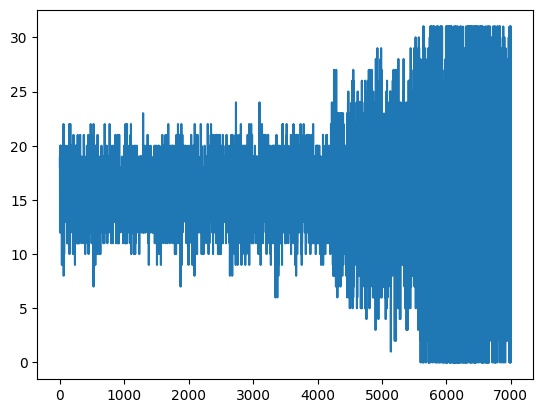

In [9]:
# 試しにアジマス0番目のレンジ行のデータをプロット
plt.plot(a_r_mtx[0,:].real)

## レンジのチャープ信号の取得




レンジのチャープ信号の取得は2種類、
- 式から直接計算する  
- メタデータのチャープレプリカを使う

があるが、ここでは式から直接計算する方法を使う

チャープ信号は大内本(第二刷) P138の式(5.24)より
$$ E_t(\tau) = E'_0\exp(i\pi f_c \tau + i \alpha t^2) $$

$f_c$ はオフセット周波数で、ここでは 0としている  
$\alpha$は、$\frac{\alpha}{\pi}$ がチャープ率となる、  ここでは RANGE_CHIRP_RATE としていて、結局
$$ E_t(\tau) = E'_0\exp(i \pi [RANGE\_CHIRP\_RATE] t^2) $$
となる

後にこれをフーリエ変換して参照信号としている  
(大内本では定常位相近似でフーリエ積分を計算しているが、ここではnumpy.fft をするだけにしている)

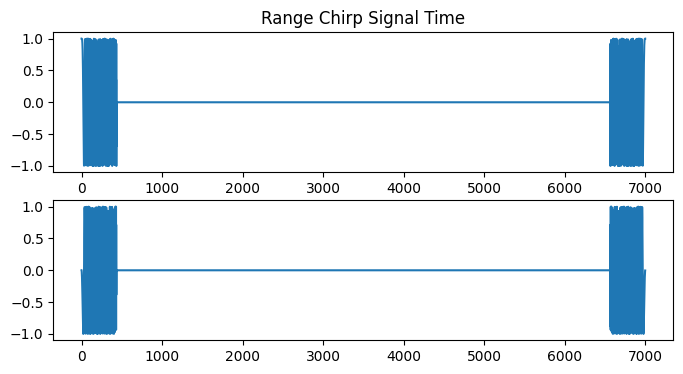

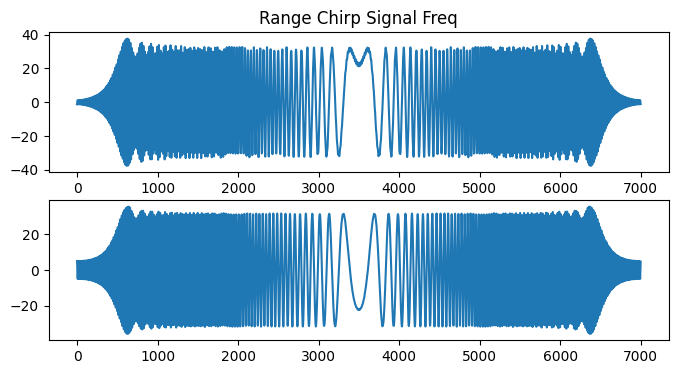

In [10]:
times = np.arange(0, PULSE_DUR, 1/SAMPLE_FREQ)
times = times-times.mean() # 時間の中心を0に
phase = np.pi*RANGE_CHIRP_RATE*times**2
chirp = np.exp(-1j*phase)

# edge_zero_pad
n_zero_pad = a_r_mtx.shape[1] - len(times)
if n_zero_pad %2 ==0:
    chirp_padded = np.pad(chirp, (int(n_zero_pad/2), int(n_zero_pad/2)))
else:
    chirp_padded = np.pad(chirp, (int(n_zero_pad/2)+1 , int(n_zero_pad/2)) )

# チャープ信号の位相をずらす
# 理由はよくわかっていないが、
# 信号成分を両端にしないと生成後の画像の位相がずれる
chirp_padded = np.roll(chirp_padded, int(len(chirp_padded)/2 ))        

fig, axes = plt.subplots(2, 1, figsize=(8, 4))
axes[0].set_title("Range Chirp Signal Time")
axes[0].plot(chirp_padded.real)
axes[1].plot(chirp_padded.imag)

# FFT
fchirp_padded = np.fft.fft(chirp_padded)
fchirp_padded_shift = np.fft.fftshift(fchirp_padded)                        
fig, axes = plt.subplots(2, 1, figsize=(8, 4))
axes[0].set_title("Range Chirp Signal Freq")
axes[0].plot(fchirp_padded_shift.real)
axes[1].plot(fchirp_padded_shift.imag)


## レンジの相関処理

#### レンジのfft

(-500.0, 500.0)

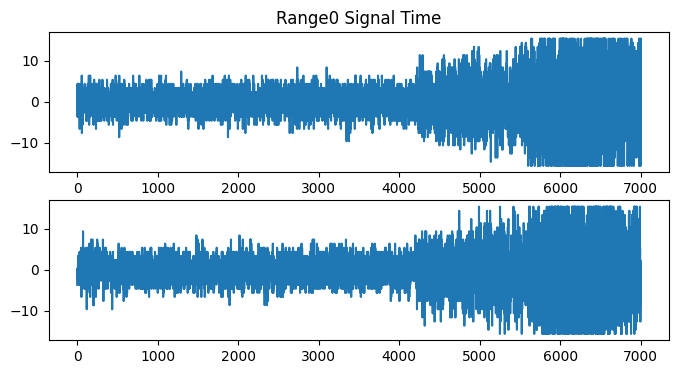

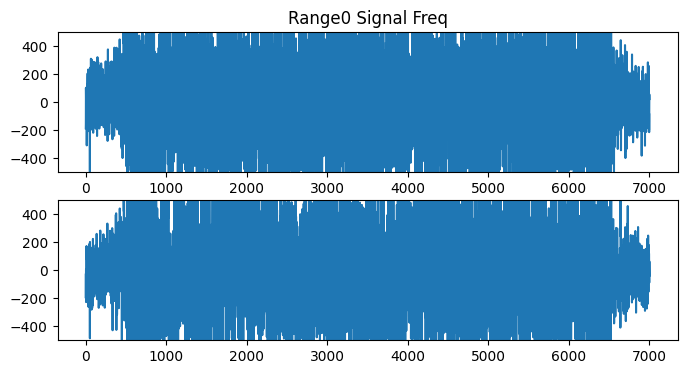

In [11]:
r_means = np.mean(a_r_mtx, axis=1)
mtx_sub = a_r_mtx - r_means[:, np.newaxis]
a_fr_mtx = np.fft.fft(mtx_sub, axis=1)
a_fr_mtx_shift = np.fft.fftshift(a_fr_mtx, axes=(1,))

fig, axes = plt.subplots(2, 1, figsize=(8, 4))
axes[0].set_title("Range0 Signal Time")
axes[0].plot(mtx_sub[0,:].real)
axes[1].plot(mtx_sub[0,:].imag)

fig, axes = plt.subplots(2, 1, figsize=(8, 4))
axes[0].set_title("Range0 Signal Freq")
axes[0].plot(a_fr_mtx_shift[0, :].real)
axes[1].plot(a_fr_mtx_shift[0, :].imag)
ly = 500
axes[0].set_ylim((-ly, ly))
axes[1].set_ylim((-ly, ly))


#### レンジの相関処理の実行

(-40.0, 40.0)

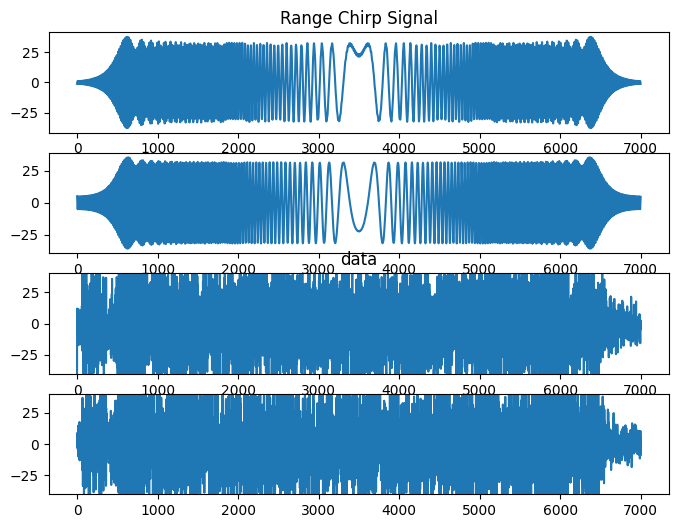

In [12]:
comp = fchirp_padded_shift[np.newaxis,:] * np.conj(a_fr_mtx_shift)
# レンジ成分を逆フーリエ変換して時間領域に戻す
a_r_rangeimage = np.fft.ifft(comp,axis=1)
range_means = np.mean(a_r_rangeimage, axis=1)
a_r_rangeimage = a_r_rangeimage - range_means[:,np.newaxis]

# plot
fig, axes = plt.subplots(4,1, figsize=(8, 6))
axes[0].set_title("Range Chirp Signal")        
axes[0].plot(fchirp_padded_shift.real)
axes[1].plot(fchirp_padded_shift.imag)        

a_fr_avr = np.average(a_fr_mtx_shift[5000:5500,:], axis=0)        
axes[2].set_title("data") 
axes[2].plot(a_fr_avr.real)
axes[3].plot(a_fr_avr.imag)
ly = 40
axes[2].set_ylim((-ly, ly))
axes[3].set_ylim((-ly, ly))


In [13]:
# 相関処理後、レンジ方向の画像の反転
# 生成後の画像を調整するために追加
a_r_rangeimage = np.fliplr(a_r_rangeimage)


True

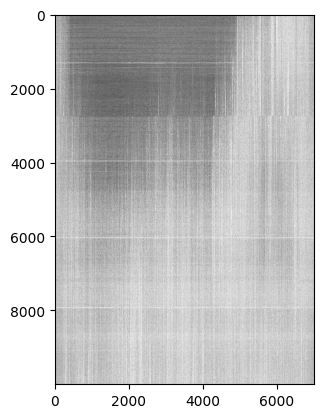

In [14]:
# 適当に規格化している
a_r_rangeimage_save = np.abs(a_r_rangeimage) / np.abs(a_r_rangeimage).max() * 10 * 255
a_r_rangeimage_save[a_r_rangeimage_save > 255] = 255
plt.imshow(a_r_rangeimage_save.astype(np.uint8), cmap="gray")
cv2.imwrite(f"{out_dir}/rangeimage.png", a_r_rangeimage_save.astype(np.uint8))


## アジマスドップラースペクトルの計算

#### 速度情報の取得

In [15]:
def get_psat_vsat_from_df(df, azm_offset, azm_length, vnorm=True):
    rel_time = df["Time s"]

    data_end_time = DATA_START_SEC + AZIMUTH_FULL/PRF
    azm_times = np.arange( DATA_START_SEC, data_end_time , 1/PRF )
    
    # sat postion
    finterp_x = interp1d(rel_time, df["x"], kind='cubic')
    finterp_y = interp1d(rel_time, df["y"], kind='cubic')
    finterp_z = interp1d(rel_time, df["z"], kind='cubic')

    sat_X = finterp_x( azm_times )
    sat_Y = finterp_y( azm_times )
    sat_Z = finterp_z( azm_times )
    sat_lla =  ecef2geodetic(sat_X, sat_Y, sat_Z)

    # sat velocity
    finterp_dx = interp1d(rel_time, df["dx"], kind='cubic')
    finterp_dy = interp1d(rel_time, df["dy"], kind='cubic')
    finterp_dz = interp1d(rel_time, df["dz"], kind='cubic')
    sat_Vx = finterp_dx(azm_times)
    sat_Vy = finterp_dy(azm_times)
    sat_Vz = finterp_dz(azm_times)
    sat_Vnorm = np.sqrt(sat_Vx**2 + sat_Vy**2 + sat_Vz**2)
    
    
    sat_lla = np.array(sat_lla)[:,azm_offset: azm_offset + azm_length]
    
    if vnorm is True:
        sat_Vnorm = sat_Vnorm[azm_offset: azm_offset + azm_length]
        return sat_lla, sat_Vnorm

    else:
        sat_V = np.array([sat_Vx, sat_Vy, sat_Vz])
        sat_V = sat_V[:,azm_offset: azm_offset + azm_length]
        return sat_lla, sat_V

lla, vsat = get_psat_vsat_from_df(satpos_df, AZM_OFFSET, N_AZMS, vnorm=True)
print(f"{lla=}, {vsat=}")

lla=array([[4.15265942e+01, 4.15266220e+01, 4.15266497e+01, ...,
        4.18040916e+01, 4.18041194e+01, 4.18041471e+01],
       [1.35010525e+02, 1.35010516e+02, 1.35010507e+02, ...,
        1.34920008e+02, 1.34919999e+02, 1.34919989e+02],
       [7.00019146e+05, 7.00019151e+05, 7.00019157e+05, ...,
        7.00076122e+05, 7.00076127e+05, 7.00076133e+05]]), vsat=array([7592.63219732, 7592.63218898, 7592.63218064, ..., 7592.54866696,
       7592.54865859, 7592.54865022])


#### 合成開口長、ポイント数


In [16]:
t_synth = LAMBDA_RADER * NEAR_RANGE_0 / D_ANTN / vsat.mean()
n_synth = int(t_synth * PRF)
if n_synth %2 !=0:
    n_synth -= 1
print(f"{t_synth=}, {n_synth=}")

t_synth=2.9646496536252753, n_synth=6388


#### アジマスドップラースペクトルの計算

大内本(第二版)のP162の式(6.20)
$$ E_r(t) = rect(t/T_A) \exp(i2\pi f_{DC}t -i\beta t^2) $$

$rect(t/T_A)$は矩形関数で、paddingで調整している  
$f_{DC}$は0として(厳密には計算が必要かも)、  
以下の単純な形で計算している

$$ E_{doppler} = e^{-i \beta t^2} $$
$$ \beta = -2 \pi \frac{v_{sat}^2}{\lambda R} {v_{corr}} $$

3611


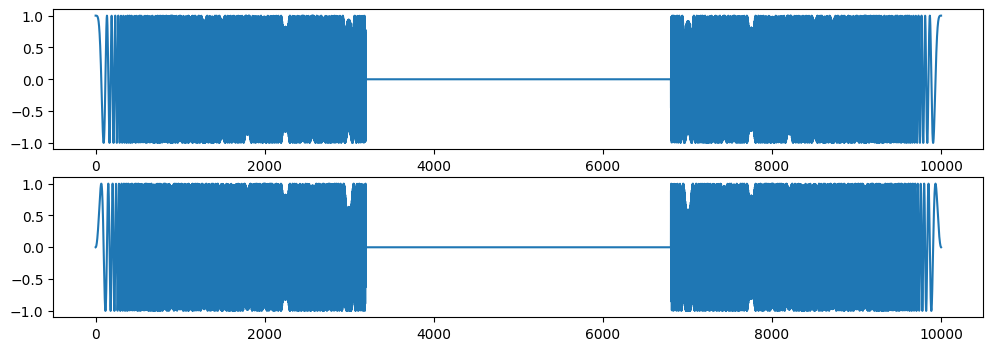

In [17]:
# 衛星の高度
satH = lla[2,:]

# アジマス周波数
azm_freqs = np.arange(0, PRF, PRF/ N_AZMS) - PRF/2
# アジマス時間
t_az = np.arange((N_AZMS))/PRF - N_AZMS/PRF/2
# レンジのサンプリング間隔
dr = VC / (2*SAMPLE_FREQ)

# レンジ距離
range_dis = NEAR_RANGE_0 + np.arange(N_RANGES)*dr

# 衛星の対地速度の補正項
Rh = satH + R_EARTH
v_corr = (R_EARTH**2 + Rh[:,np.newaxis]**2 - range_dis**2)/(2*Rh[:,np.newaxis]**2)

# ドップラースペクトラムの計算
# vsatはノルムをそのまま使っているが、これはalosの軌道傾斜角が98.16でほぼ南北方向に一致していると考えている  
# 厳密には速度成分を南北成分に分解する必要があるかもしれないかも
beta = -2*np.pi*(vsat[:,np.newaxis])**2/LAMBDA_RADER/range_dis*v_corr
dplr_spec_phase =  beta * t_az[:,np.newaxis]**2
dplr_spec = np.exp(-1j*dplr_spec_phase)

# ビーム幅 (合成開口幅)の計算
# 速度は平均値を使っている (厳密にはアジマス列ごとに計算する必要がある)
fig, axes = plt.subplots(2,1, figsize=(12,4))
beam_width = NEAR_RANGE_0 * LAMBDA_RADER/ D_ANTN
beam_time = beam_width/vsat.mean()
beam_points = int(beam_time* PRF)        
not_beam_points = N_AZMS - beam_points

# 合成開口の領域以外を0にする
dplr_spec_synth = dplr_spec.copy()
dplr_spec_synth[ :not_beam_points//2  ,:] = 0
dplr_spec_synth[ -not_beam_points//2: ,:] = 0
print(not_beam_points)

# 信号の位相の調整
dplr_spec_synth = np.roll(dplr_spec_synth, len(dplr_spec_synth)//2 ,axis=0)

# ドップラースペクトルのプロット
axes[0].plot(dplr_spec_synth[:,0].real)
axes[1].plot(dplr_spec_synth[:,0].imag)



#### アジマスの相関処理の実行

In [18]:
# 画像のアジマス両端は合成開口に入らないので0にする
a_r_rangeimage[:n_synth//2, :] = 0
a_r_rangeimage[-n_synth//2:, :] = 0

# アジマス方向のfft
fazm_image = np.fft.fft(a_r_rangeimage, axis=0)
fazm_image = np.fft.fftshift(fazm_image, axes=(0,))

#fazm_image = sardata.range_migraion(rangeimage_fa_r, beta)

f_dplr_spec_synth = np.fft.fft(dplr_spec_synth, axis=0)
f_dplr_spec_synth = np.fft.fftshift(f_dplr_spec_synth, axes=(0,))
comp = f_dplr_spec_synth * np.conj(fazm_image)

ar_image = np.fft.ifft(comp, axis=0)
azm_means = np.mean(ar_image, axis=0)
image = ar_image - azm_means[np.newaxis, :]

3825.0


True

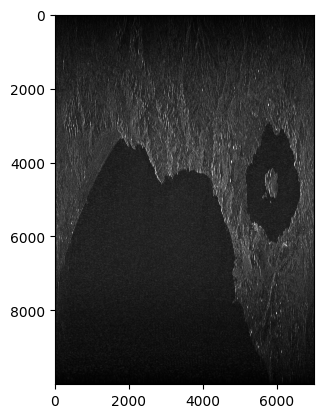

In [28]:
# 適当に規格化している
image_save = np.abs(image) / np.abs(image).max() * 15 * 255
print(image_save.max())
image_save[image_save > 255] = 255
plt.imshow(image_save.astype(np.uint8), cmap="gray")
cv2.imwrite(f"{out_dir}/image.png", image_save.astype(np.uint8))



#### 簡単なアスペクトの調整
元データではアジマス分解能とレンジ分解能が異なるので、生成画像のアスペクトが異なっている。  
調整するためには、どちらかの分解能を揃える必要がある。  
ここでは、アジマスの分解能力に揃えて、レンジを拡大している  
倍率は 1点あたりのアジマス距離と、1点あたりのレンジ距離の比率をおおまかに計算している  


drange=2.6397009274805896, dazm=3.5229626453296645


True

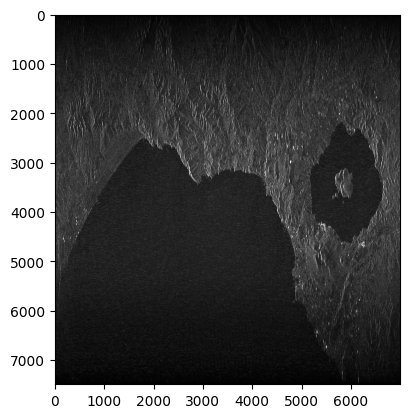

In [29]:
# シーン中心付近のレンジ距離、グランドレンジ距離の変化量を取得
center_ranges = range_dis[N_RANGES // 2 : N_RANGES // 2 + 2]
center_ranges_ground = center_ranges * np.sin(np.deg2rad(OFF_NADIR_ANGLE))
drange = center_ranges_ground[1] - center_ranges_ground[0]

# 厳密にはアジマス列ごとに計算する必要があるだろう
dazm = 1/PRF*vsat.mean()
print(f"{drange=}, {dazm=}")
image_save_corr = cv2.resize(image_save, None, fx=1, fy=drange/dazm)
plt.imshow(image_save_corr.astype(np.uint8), cmap="gray")
cv2.imwrite(f"{out_dir}/image_corr.png", image_save_corr.astype(np.uint8))